In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau


# Just convert to tensor for now (0–1 range)
learning_rate = 1e-3
batch_size = 64
epochs = 10
accuracies = []
losses = []
epochs = []

mean = [0.47889522, 0.47227842, 0.43047404]
std = [0.24205776, 0.23828046, 0.25874835]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

training_data = datasets.ImageFolder(root="./cinic-10/train", transform=transform)
test_data = datasets.ImageFolder(root="./cinic-10/test", transform=transform)
validation_data = datasets.ImageFolder(root="./cinic-10/valid", transform=transform)


# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break
eval_data = datasets.ImageFolder(root="./cinic-10/valid", transform=transform)
eval_loader = DataLoader(validation_data, batch_size=64, shuffle=False)

Shape of X [N, C, H, W]: torch.Size([64, 3, 32, 32])
Shape of y: torch.Size([64]) torch.int64


In [20]:
class BatchNormalized(nn.Module):
    def __init__(self, input_features = 3 * 32 * 32, hidden_layer1 = 1024, hidden_layer2 = 512, hidden_layer3 = 256, output_features =10):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_features, 1024),  # input layer
            nn.ReLU(),  # activation function
            nn.BatchNorm1d(1024), # Batch Normalization
            nn.Linear(1024, 512),  # hidden layer (1st)
            nn.ReLU(),  # activation function
            nn.BatchNorm1d(512), # Batch Normalization
            nn.Linear(512, 256),  # hidden layer (1st)
            nn.ReLU(),  # activation function
            nn.Linear(256, 128),  # hidden layer (2nd)
            nn.ReLU(),  # activation function
            nn.BatchNorm1d(128), # Batch Normalization
            nn.Linear(128, 64), 
            nn.ReLU(),  # activation function
            nn.Linear(64, output_features),   # output logits
        )
    def forward(self, x):
            x = self.flatten(x)
            logits = self.linear_relu_stack(x)
            return logits

In [21]:
# Define model
class VanillaDNN(nn.Module):
    def __init__(self, input_features = 3 * 32 * 32, hidden_layer1 = 1024, hidden_layer2 = 512, hidden_layer3 = 256, output_features =10):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_features, 1024),  # input layer
            nn.ReLU(),  # activation function
            nn.Linear(1024, 512),  # hidden layer (1st)
            nn.ReLU(),  # activation function
            nn.Linear(512, 256),  # hidden layer (1st)
            nn.ReLU(),  # activation function
            nn.Linear(256, 128),  # hidden layer (2nd)
            nn.ReLU(),  # activation function
            nn.Linear(128, 64), 
            nn.ReLU(),  # activation function
            nn.Linear(64, output_features),   # output logits
        )


    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = BatchNormalized()
print(model)    
torch.manual_seed(63)                                                                                                                                                        

BatchNormalized(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=1024, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Linear(in_features=128, out_features=64, bias=True)
    (12): ReLU()
    (13): Linear(in_features=64, out_features=10, bias=True)
  )
)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7030174..1.6991849].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4600028..1.046205].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8503652..2.1324189].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6485225..1.7209742].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4600028..1.046205].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8503652..2.1324189].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6485225.

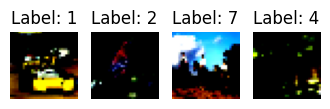

In [22]:
def show_images_from_loader(data_loader, n=4):
 
    # Get a batch of images from the data loader
    images, labels = next(iter(data_loader))

    # Select the first n images and labels
    images = images[:n]
    labels = labels[:n]

    # Create a grid of images
    fig, axes = plt.subplots(1, n, figsize=(n * 1, 1))
    for i in range(n):
        ax = axes[i]
        img = images[i].numpy().transpose((1, 2, 0))  # Convert to HWC format
        ax.imshow(img)
        ax.set_title(f"Label: {labels[i].item()}")
        ax.axis('off')
    plt.show()
show_images_from_loader(train_dataloader, n=4)

In [23]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer,mode='min',factor=0.1,patience=5)

In [24]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    print(size)
    model.train()
    for batch, (X, y) in enumerate(dataloader):

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    

In [25]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct

In [26]:
import torch
import os

def train_and_validate(
    epochs, 
    training_dataloader, 
    test_dataloader, 
    model, 
    loss_fn, 
    optimizer, 
    scheduler, 
    checkpoint_dir='saved_models'
):
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    best_loss = float('inf')
    val_losses = []
    train_losses = []

    for t in range(epochs):
        print(f"Epochs------------{t+1}")
        print("__________________________")
        train(training_dataloader, model, loss_fn, optimizer)
        val_loss = test(test_dataloader, model, loss_fn, t)


        if val_loss > best_loss:
            best_loss = val_loss
            checkpoint_path = os.path.join(checkpoint_dir, f'saved_model_epoch_loss_{val_loss:.4f}.pt')
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Best Loss: {val_loss:>8f}. Model checkpoint created and saved at {checkpoint_path}.")
        print(val_losses, train_losses)
    print("===========================================")
    print(f"Best Loss: {best_loss:>8f}. Training Complete.")

    # Save final model
    torch.save(model.state_dict(), os.path.join(checkpoint_dir, 'final_model.pt'))

In [27]:
epoch = 12


for t in range(epoch):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    accuracy, loss = test(test_dataloader, model, loss_fn)
    accuracies.append(accuracy)
    losses.append(loss)
    epochs.append(t)


print("Done!")
# train_and_validate(epochs, train_dataloader, test_dataloader, model, loss_fn, optimizer)

Epoch 1
-------------------------------
90000
loss: 2.279621  [   64/90000]
loss: 1.781027  [ 6464/90000]
loss: 1.781027  [ 6464/90000]
loss: 1.743964  [12864/90000]
loss: 1.743964  [12864/90000]
loss: 1.840557  [19264/90000]
loss: 1.840557  [19264/90000]
loss: 1.777113  [25664/90000]
loss: 1.777113  [25664/90000]
loss: 1.758086  [32064/90000]
loss: 1.758086  [32064/90000]
loss: 1.503594  [38464/90000]
loss: 1.503594  [38464/90000]
loss: 1.755833  [44864/90000]
loss: 1.755833  [44864/90000]
loss: 1.871485  [51264/90000]
loss: 1.871485  [51264/90000]
loss: 1.675885  [57664/90000]
loss: 1.675885  [57664/90000]
loss: 1.524428  [64064/90000]
loss: 1.524428  [64064/90000]
loss: 1.714230  [70464/90000]
loss: 1.714230  [70464/90000]
loss: 1.557276  [76864/90000]
loss: 1.557276  [76864/90000]
loss: 1.895884  [83264/90000]
loss: 1.895884  [83264/90000]
loss: 1.834966  [89664/90000]
loss: 1.834966  [89664/90000]
Test Error: 
 Accuracy: 38.8%, Avg loss: 1.678837 

Epoch 2
------------------------

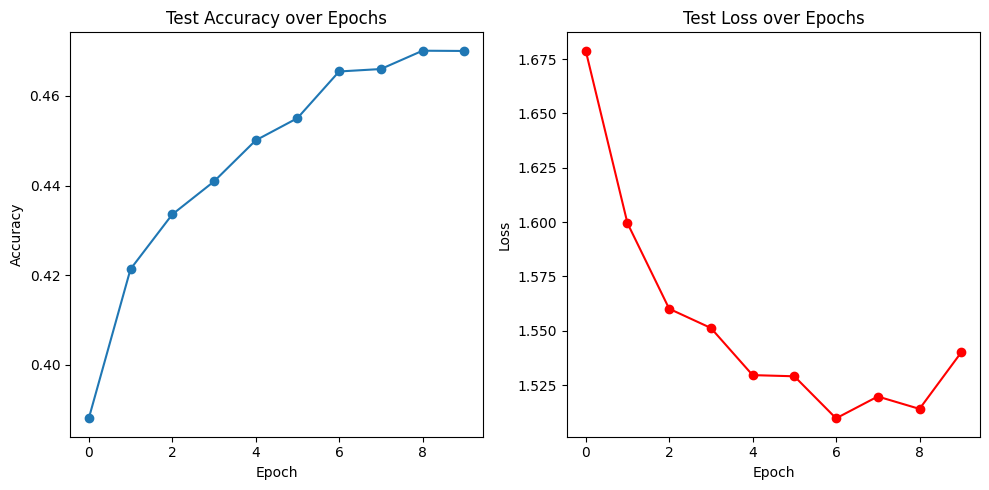

In [31]:
import matplotlib.pyplot as plt

# 📊 Plotting
plt.figure(figsize=(10,5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, losses, marker='o')
plt.title("Test Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, marker='o', color='red')
plt.title("Test Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.tight_layout()
plt.show()

In [35]:
print("Accuracy:", accurarcies)
print("Losses:", losses)
print(epochs)

Accuracy: [1.678837408219658, 1.5995015291432244, 1.560132997461304, 1.5512891423431117, 1.5296155517416468, 1.5290812341219666, 1.509737255646137, 1.5197816892092162, 1.5140805552636127, 1.540079883632714]
Losses: [0.38803333333333334, 0.42134444444444447, 0.43354444444444445, 0.4409, 0.4500777777777778, 0.45503333333333335, 0.46545555555555557, 0.466, 0.4700888888888889, 0.47003333333333336]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [32]:
#Saving the model
torch.save(model.state_dict(), "./my_models/batchNormed2.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth
